# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [24]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax
from jax import random

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2
from tqdm import tqdm

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

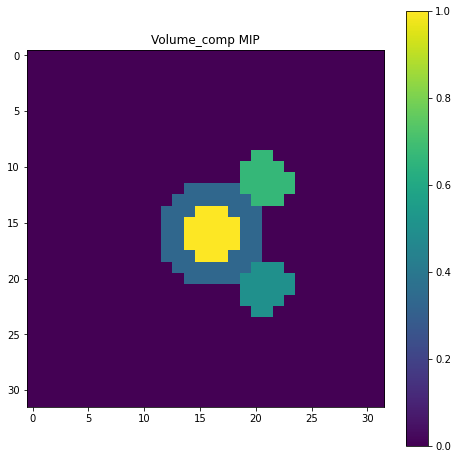

In [3]:
nx = 32
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

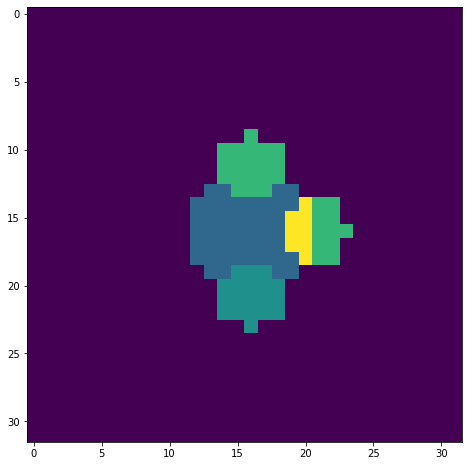

In [4]:
mip_y(vol)

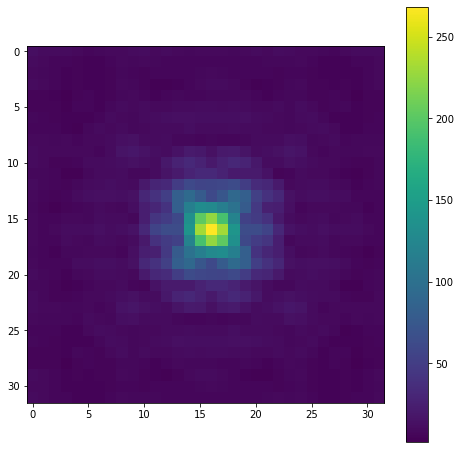

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


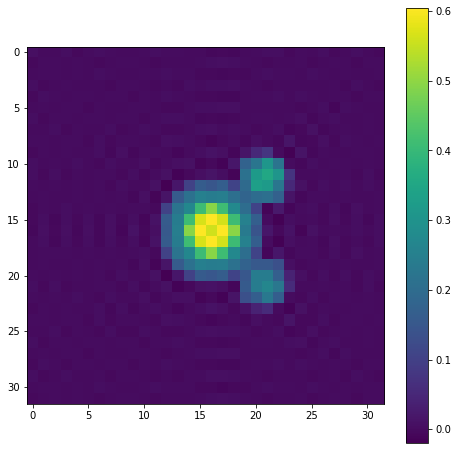

In [7]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")
s = 17
img = slice_func(0.1*vol_fourier, [0,0,0], [0,0], None)
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx,nx]))))) 
plt.imshow(img_r); plt.colorbar()

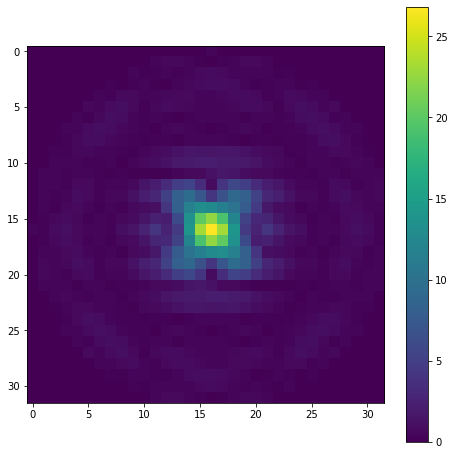

In [8]:
img_f0 = jnp.fft.fftshift(img.reshape([nx,nx]))
plt.imshow(jnp.abs(img_f0));plt.colorbar()

Generate projections (in Fourier domain)

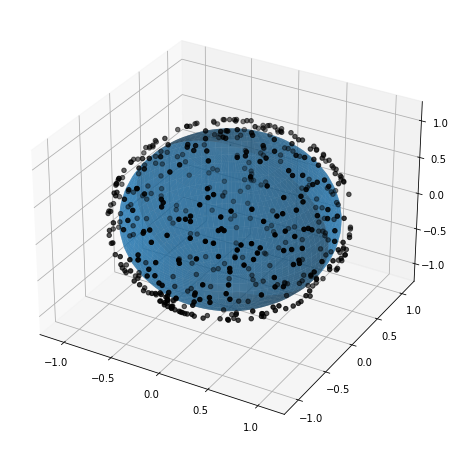

In [9]:
# Orientations
N = 5000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

In [10]:
from src.utils import *

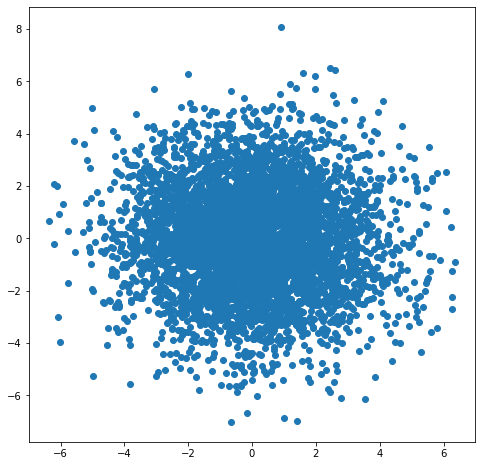

In [11]:
# Shifts
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, subkey = random.split(key)
#shifts_true = generate_uniform_shifts(key, N, pixel_size*nx/2)
shifts_true = generate_gaussian_shifts(key, N, pixel_size*nx/10)

#shifts_true = jnp.zeros([N,3])

plt.scatter(shifts_true[:,0], shifts_true[:,1])

SNR = 0.14308783830274405
sigma = 37.84951113740297


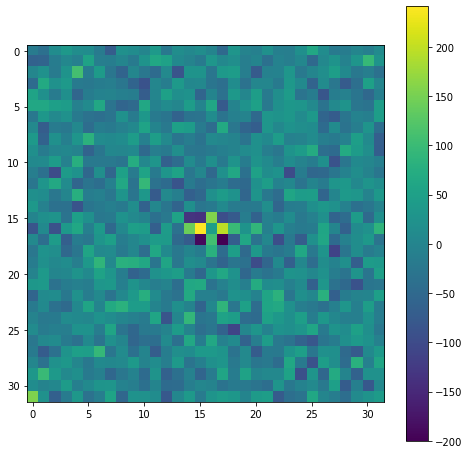

In [12]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

# If too many images which don't fit in the gpu memory, do this:
#imgs = jnp.array([slice_func(vol_fourier, angles_true[i], shifts_true[i], ctf_params0) for i in range(N)])

norm0sq = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
sigma = 0.2 * jnp.max(jnp.abs(img0))
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * sigma

norm1sq = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

#print(time.time()-start)

#SNR
print("SNR =", norm0sq/norm1sq)
print("sigma =", sigma)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[101].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [13]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

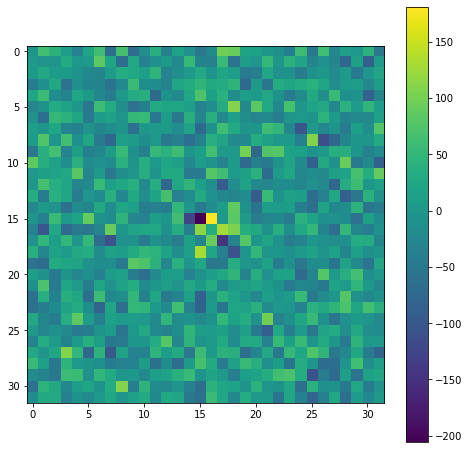

In [14]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

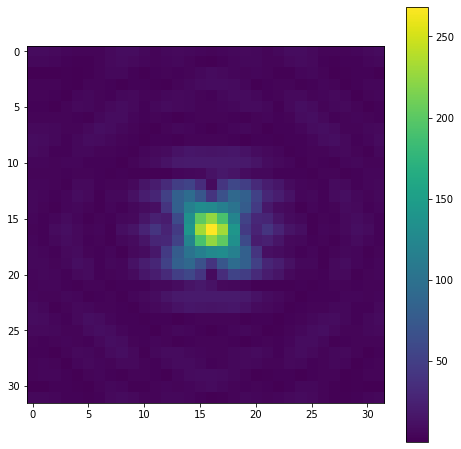

In [15]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

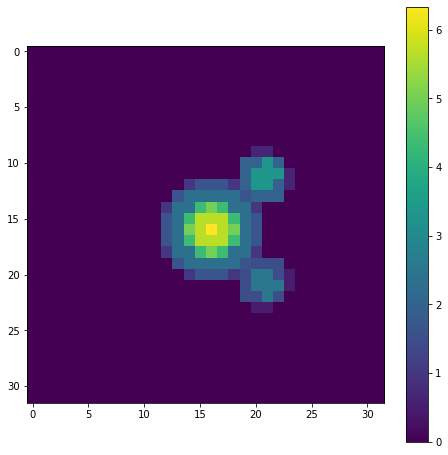

In [16]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

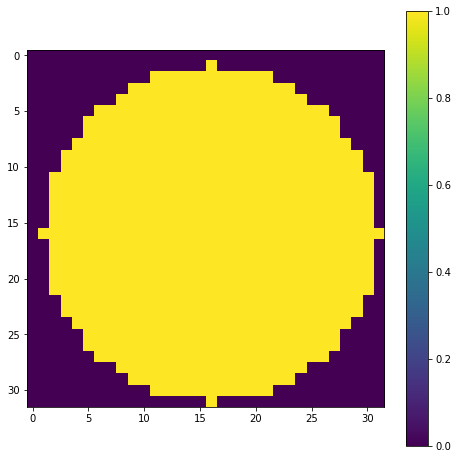

In [17]:
alpha = 0.01
#alpha = 1/N

#radius = 0.4 # for nx=16
radius = 0.75 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [18]:
sigma_noise = jnp.ones(nx*nx) * sigma

In [19]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20], sigma_noise)
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

5.666037321090698
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [20]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0], sigma_noise)
print(time.time()-start)
print(ll.shape)

1.6631784439086914
(32, 32, 32)


In [21]:
batch_size = N
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_sum(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx], sigma_noise)
print(time.time()-start)
print(ll.shape)

2.2958621978759766
(32, 32, 32)


### MCMC - vol

In [570]:
vol_fourier.shape

(32, 32, 32)

In [571]:
def plot_true_vs_estimated(vol_true, vol_estimated):

    plt.rcParams["figure.figsize"]=16,16
    plt.subplot(2,2,1)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_true[:,:,0]))); plt.colorbar()
    plt.title('True')
    plt.subplot(2,2,2)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_estimated[:,:,0]))); plt.colorbar()
    plt.title('Sampled')
    plt.subplot(2,2,3)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_true[:,:,0])))); 
    plt.colorbar()
    plt.title('True')
    plt.subplot(2,2,4)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_estimated[:,:,0])))); 
    plt.colorbar()
    plt.title('Estimated')

    plt.rcParams["figure.figsize"]=8,8

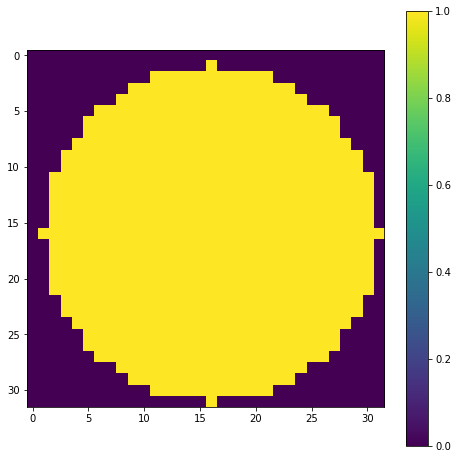

In [572]:
#alpha = 1e-10
#alpha = 0.001



radius_mask = 0.75 # nx=16
#radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0), radius_mask)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_true, ctf_params, imgs, 1)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_true, ctf_params, imgs, 1))



In [573]:
alpha

0.01

In [574]:
dt_list = jnp.array([0.5])
L = 10
M = 1

@jax.jit
def proposal_hmc_jit(key, x0):
    return proposal_hmc(key, x0, logPi, gradLogPi, dt_list, L, M)

In [578]:
N_mc_samples = 41

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) 
#v0 = v_rec

t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, proposal_hmc_jit, v0, N_mc_samples, logPi)
print((time.time() - t0)/N_mc_samples)
v_hmc_mean = v_hmc_mean * mask

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 1518604.05834707
  Iter 40 , a =  0.7226031956801297
  MC sample 40 , loss (of mean) = 1516776.0628889888
0.3245431271994986


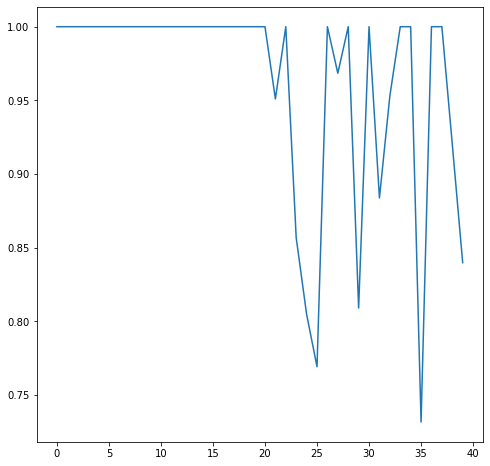

In [567]:
plt.plot(r_hmc)

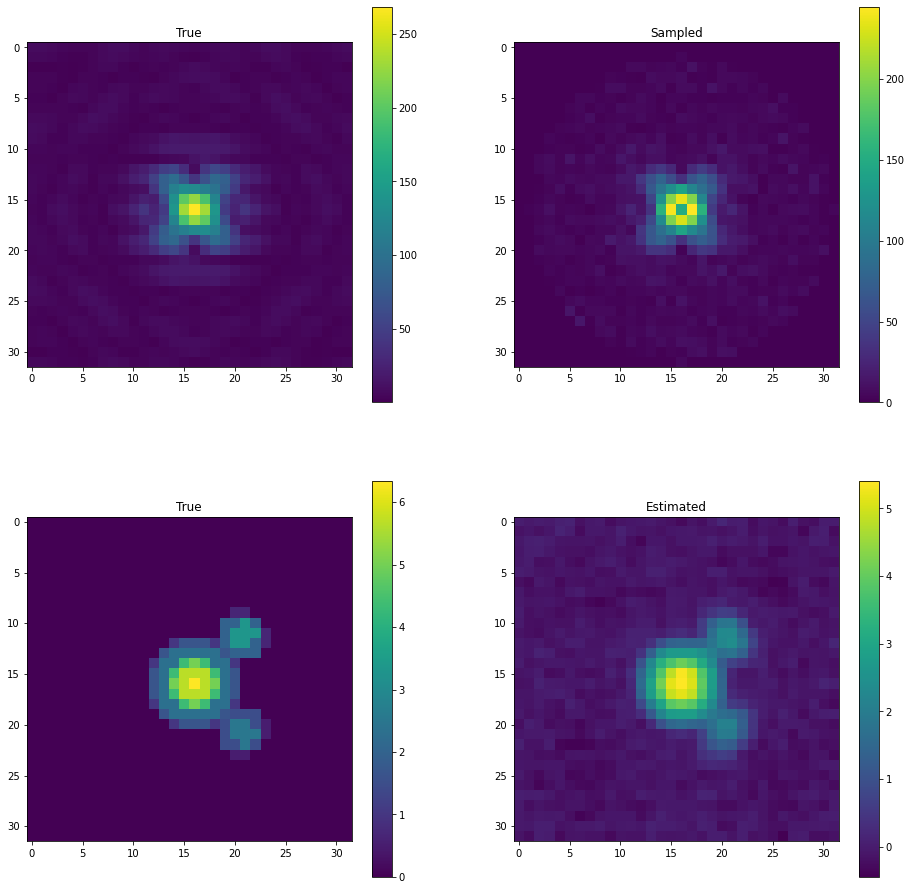

In [579]:
plot_true_vs_estimated(vol_fourier, v_hmc_mean)

In [580]:
print(loss_func_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))
print(loss_func_sum(v_hmc_mean, angles_rec, shifts_true, ctf_params, imgs, 1))
#print(loss_func_sum(v_rec, angles_rec, shifts_true, ctf_params, imgs, 1))
#print(loss_func_sum(vcg1, angles_rec, shifts_true, ctf_params, imgs, 1))

1502557.17884119
1514067.1703557626


### MCMC - orientations

In [601]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_batch = lambda a : -loss_func_batched(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

def proposal_uniform_orientations_func(key, x0):
    return proposal_uniform_orientations(key, x0, logPi_batch)

In [605]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_mc_samples = 1001

angles0 = generate_uniform_orientations_jax(key, N)
t0 = time.time()
angles_mean, r_samples_angles, samples_angles = mcmc(key, proposal_uniform_orientations_func, angles0, N_mc_samples, logPi_batch, N)
print(time.time() - t0)

angles_rec = samples_angles[0]

  MC sample 100 , loss = 1505392.7477273722
  MC sample 200 , loss = 1499942.0986200569
  MC sample 300 , loss = 1497117.3355399508
  MC sample 400 , loss = 1495357.1026216724
  MC sample 500 , loss = 1494026.7731443157
  MC sample 600 , loss = 1493032.9848531063
  MC sample 700 , loss = 1492355.393501351
  MC sample 800 , loss = 1491672.4334722897
  MC sample 900 , loss = 1491130.1652607739
  MC sample 1000 , loss = 1490654.016007777
49.83778977394104


In [606]:
key, *keys = random.split(key, N_mc_samples + 1)
angles0 = generate_uniform_orientations_jax(key, N)
#print(jnp.mean(loss_angles(angles0))/(nx*nx*jnp.max(jnp.abs(imgs))))
print(jnp.max(jnp.abs(logPi_batch(angles0))))

t0 = time.time()
for i in range(N_mc_samples):
    angles1 = mcmc_batch_step(keys[i], N_mc_samples, logPi_batch, angles0)
    angles0 = angles1
    
    if jnp.mod(i, 100) == 0:
        #loss_i = jnp.mean(loss_angles(angles1))/(nx*nx*jnp.max(jnp.abs(imgs)))
        loss_i = jnp.max(jnp.abs(logPi_batch(angles1)))
        print("Iter", i, ", loss = " ,loss_i)
        
print(time.time()-t0)

1817322.1448786615
Iter 0 , loss =  1798915.4524078316
Iter 100 , loss =  1694530.4329539621
Iter 200 , loss =  1694530.4329539621
Iter 300 , loss =  1676713.6302346857
Iter 400 , loss =  1676713.6302346857
Iter 500 , loss =  1668790.5203267203
Iter 600 , loss =  1668790.5203267203
Iter 700 , loss =  1667220.8750247858
Iter 800 , loss =  1667220.8750247858
Iter 900 , loss =  1667220.8750247858
Iter 1000 , loss =  1667220.8750247858
49.60457730293274


In [607]:
angles0 = generate_uniform_orientations_jax(key, N)

print(jnp.max(jnp.abs(logPi_batch(angles0))))
print(jnp.max(jnp.abs(logPi_batch(angles_true))))
print(jnp.max(jnp.abs(logPi_batch(angles1))))
print(jnp.max(jnp.abs(logPi_batch(angles_rec))))

1817322.1448786615
1657585.0466964685
1667220.8750247858
1673476.6783362867


### MCMC shifts

#### Naive

In [35]:
alpha0 = 0
B = pixel_size*nx/10

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_shifts = lambda sh : -loss_func_batched(vol_fourier, angles_true, sh, ctf_params, imgs, 1)


def proposal_uniform_shifts_func(key, x0):
    return proposal_uniform_shifts(key, x0, logPi_shifts, B)

In [36]:
B

2.0

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_mc_samples = 2001

shifts0 = generate_uniform_shifts(key, N, B)
t0 = time.time()
_, r_samples_shifts, shifts_samples = mcmc(key, proposal_uniform_shifts_func, shifts0, N_mc_samples, logPi_shifts, N)
print(time.time()-t0)

shifts_rec = shifts_samples[0]

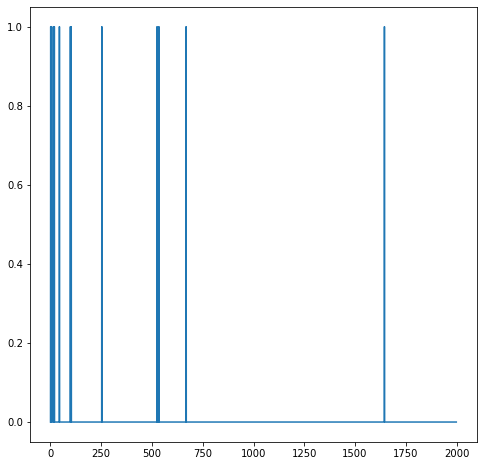

In [619]:
plt.plot(r_samples_shifts[:,10])

mean shift error = 0.2606278306450639 in [ -10.0 , 10.0 ]^2


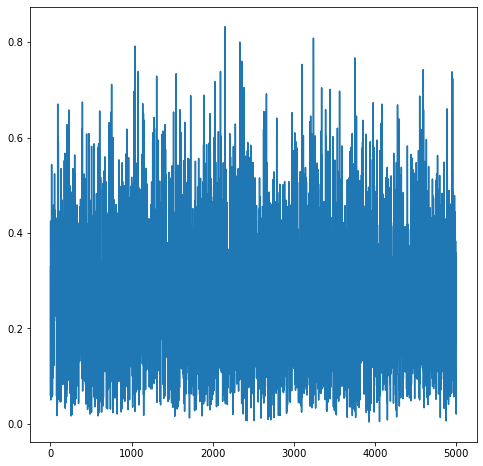

In [620]:
shifts_err = wrap_arround_distance_2d_array(shifts_true, shifts_rec, B)
print("mean shift error =", jnp.mean(shifts_err), "in [", -B, ",", B, "]^2")
plt.plot(shifts_err)

#### Optimised

In [40]:
alpha0 = 0
B = pixel_size*nx/10

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

proj = jax.vmap(rotate_and_interpolate, in_axes=(None,0,None,None))(vol_fourier*mask, angles_true, x_grid, x_grid)

In [45]:
from src.projection import apply_shifts_and_ctf
from src.jaxops import *

loss_proj_func_batched = get_loss_proj_funcs(apply_shifts_and_ctf, x_grid, alpha = alpha0)
logPi_shifts = lambda sh : -loss_proj_func_batched(vol_fourier, proj, sh, ctf_params, imgs, 1)

@jax.jit
def proposal_uniform_shifts_func(key, x0):
    return proposal_uniform_shifts(key, x0, logPi_shifts, B)

@jax.jit
def proposal_gaussian_shifts_func(key, x0):
    return proposal_gaussian_shifts(key, x0, logPi_shifts, B)


In [66]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_mc_samples = 101

shifts0 = generate_gaussian_shifts(key, N, B)
t0 = time.time()
_, r_samples_shifts, shifts_samples = mcmc(key, proposal_gaussian_shifts_func, shifts0, N_mc_samples, logPi_shifts, N)
print(time.time()-t0)

shifts_rec = shifts_samples[0]

  MC sample 100 , loss = 1491121.6395698076
1.5344204902648926


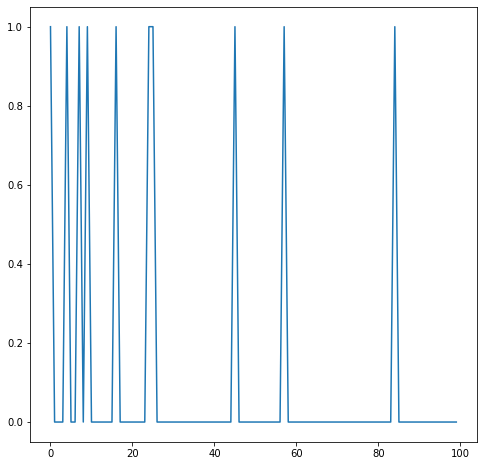

In [67]:
plt.plot(r_samples_shifts[:,10])

mean shift error = 0.4757312914767468 in [ -2.0 , 2.0 ]^2


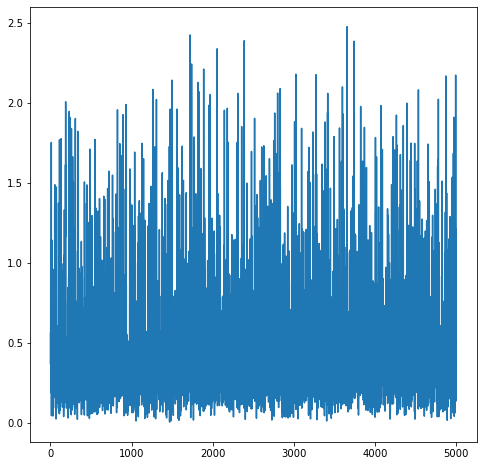

In [68]:
shifts_err = wrap_arround_distance_2d_array(shifts_true, shifts_rec, B)
print("mean shift error =", jnp.mean(shifts_err), "in [", -B, ",", B, "]^2")
plt.plot(shifts_err)

### Ab initio

Fourier radius: 0.8
Starting radius: 0.2
Frequency marching step size: 0.05
Number of frequency marching steps: 13
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 3.12001140290537e-05
  sgd epoch 10: mean gradient = 3.06037352588703e-05
  sgd epoch 20: mean gradient = 2.936734289213821e-05
  sgd epoch 30: mean gradient = 2.80707549234236e-05
  sgd epoch 40: mean gradient = 2.898391987761985e-05
  sgd epoch 50: mean gradient = 2.860365166866362e-05
  sgd epoch 60: mean gradient = 2.6986630635423875e-05
  sgd epoch 70: mean gradient = 2.7760189619911046e-05
  sgd epoch 80: mean gradient = 2.6016810565104555e-05
  sgd epoch 90: mean gradient = 2.5325728592631342e-05
  sgd epoch 100: mean gradient = 2.6838419648599242e-05
  sgd epoch 110: mean gradient = 2.490814849739137e-05
  sgd epoch 120: mean gradient = 2.7316097085368533e-05
  sgd epoch 130: mean gradient = 2.5679451584975214e-05
  sgd epoch 140: mean gradient = 2.383246917772733e-05
  sgd ep

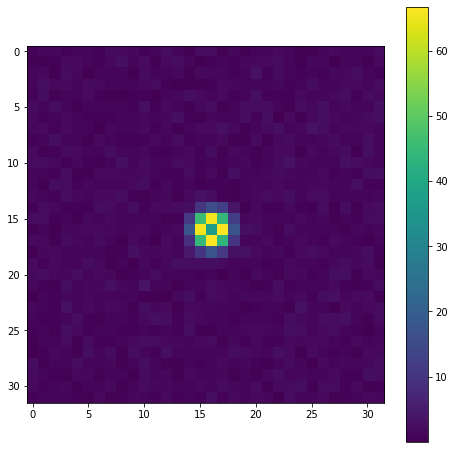

Iter  0
Sampling orientations
  MC sample 100 , loss = 173.68153416577672
  MC sample 200 , loss = 173.67559635376017
  MC sample 300 , loss = 173.67750558494114
  MC sample 400 , loss = 173.67397656672344
  MC sample 500 , loss = 173.67270849951663
  MC sample 600 , loss = 173.68623379447337
  MC sample 700 , loss = 173.6790706133951
  MC sample 800 , loss = 173.67351573004382
  MC sample 900 , loss = 173.6906676480376
  Time orientations sampling = 11.996482133865356
  mean(a_angles) = 0.5161582461768696
Sampling shifts
  MC sample 100 , loss = 157.9262301085497
  MC sample 200 , loss = 157.63255736281127
  MC sample 300 , loss = 157.54603811178526
  MC sample 400 , loss = 157.50615038894242
  MC sample 500 , loss = 157.49210316912615
  MC sample 600 , loss = 157.46031086569866
  MC sample 700 , loss = 157.45213814807633
  MC sample 800 , loss = 157.43555489791365
  MC sample 900 , loss = 157.42869835584867
  Time shifts sampling = 8.968703031539917
  mean(a_shifts) = 0.0451262936294

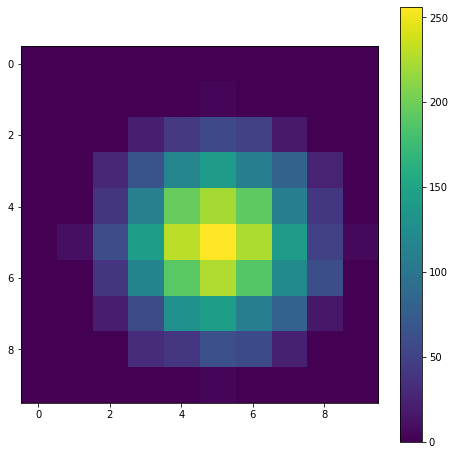

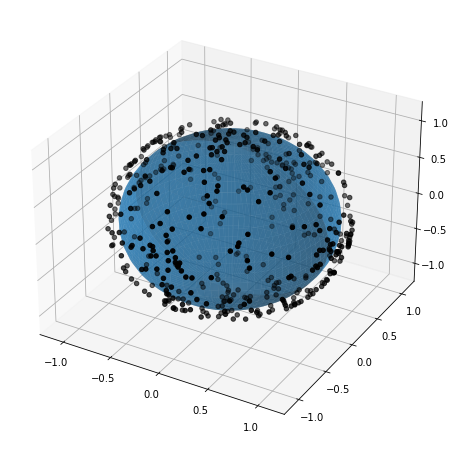

Iter  1
Sampling orientations
  MC sample 100 , loss = 103.52996154522894
  MC sample 200 , loss = 103.53710950941195
  MC sample 300 , loss = 103.53276863099536
  MC sample 400 , loss = 103.53809258991596
  MC sample 500 , loss = 103.52773096123705
  MC sample 600 , loss = 103.53768348428345
  MC sample 700 , loss = 103.54885479690687
  MC sample 800 , loss = 103.51277138386752
  MC sample 900 , loss = 103.49109920758475
  Time orientations sampling = 13.090420007705688
  mean(a_angles) = 0.3786158637765598
Sampling shifts
  MC sample 100 , loss = 99.20999749880195
  MC sample 200 , loss = 98.30936927557302
  MC sample 300 , loss = 97.93881573778955
  MC sample 400 , loss = 97.72461647935182
  MC sample 500 , loss = 97.58121306859243
  MC sample 600 , loss = 97.49229335433327
  MC sample 700 , loss = 97.42899474449808
  MC sample 800 , loss = 97.3800807676142
  MC sample 900 , loss = 97.31330531838312
  Time shifts sampling = 9.263308763504028
  mean(a_shifts) = 0.006933354247462586
S

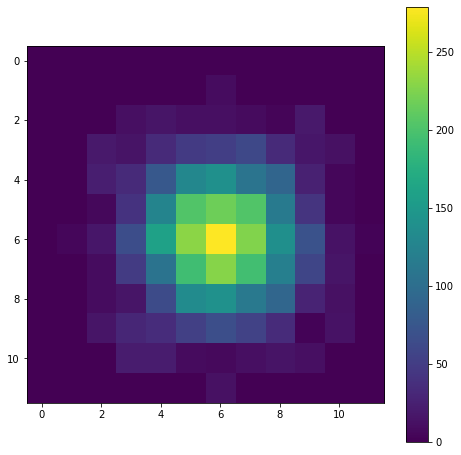

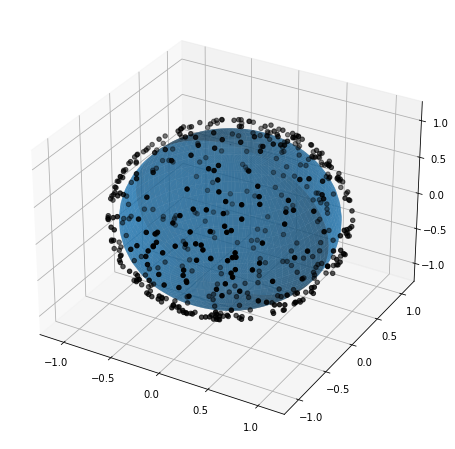

Iter  2
Sampling orientations
  MC sample 100 , loss = 95.06399262909233
  MC sample 200 , loss = 94.96378263824197
  MC sample 300 , loss = 94.95529981616049
  MC sample 400 , loss = 94.93014596252333
  MC sample 500 , loss = 94.95895364589053
  MC sample 600 , loss = 94.9290396489984
  MC sample 700 , loss = 94.941826551709
  MC sample 800 , loss = 94.9322266051525
  MC sample 900 , loss = 94.92401746656961
  Time orientations sampling = 13.163920879364014
  mean(a_angles) = 0.20733615933803967
Sampling shifts
  MC sample 100 , loss = 94.91828663741079
  MC sample 200 , loss = 94.87874346028218
  MC sample 300 , loss = 94.85915700636492
  MC sample 400 , loss = 94.84001630655793
  MC sample 500 , loss = 94.8027483632157
  MC sample 600 , loss = 94.776210326794
  MC sample 700 , loss = 94.76129214753458
  MC sample 800 , loss = 94.75558886912013
  MC sample 900 , loss = 94.74533684307903
  Time shifts sampling = 8.398141384124756
  mean(a_shifts) = 0.005124365135990597
Sampling the vo

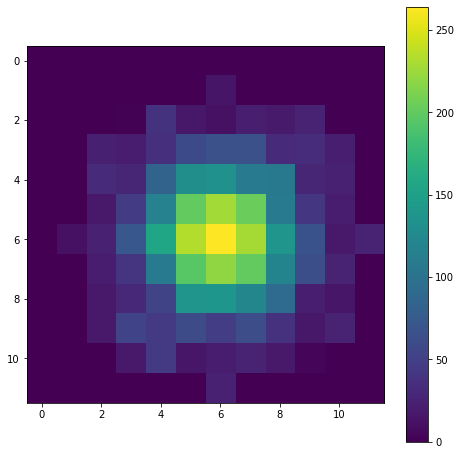

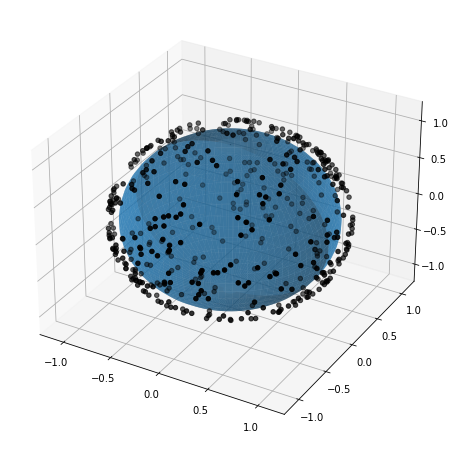

Iter  3
Sampling orientations
  MC sample 100 , loss = 90.03087415928177
  MC sample 200 , loss = 89.5983553940225
  MC sample 300 , loss = 89.45164358290083
  MC sample 400 , loss = 89.3025842939948
  MC sample 500 , loss = 89.19445150382535
  MC sample 600 , loss = 89.10469726850067
  MC sample 700 , loss = 89.065956374104
  MC sample 800 , loss = 88.99613325523048
  MC sample 900 , loss = 88.97851534682145
  Time orientations sampling = 13.131903648376465
  mean(a_angles) = 0.03303863754997084
Sampling shifts
  MC sample 100 , loss = 88.83294748824254
  MC sample 200 , loss = 88.76722161644412
  MC sample 300 , loss = 88.71620457276852
  MC sample 400 , loss = 88.70615477637483
  MC sample 500 , loss = 88.70109257967219
  MC sample 600 , loss = 88.67569043069365
  MC sample 700 , loss = 88.6552539413956
  MC sample 800 , loss = 88.64550561952727
  MC sample 900 , loss = 88.61867868464438
  Time shifts sampling = 9.342849254608154
  mean(a_shifts) = 0.0045420870621048414
Sampling the

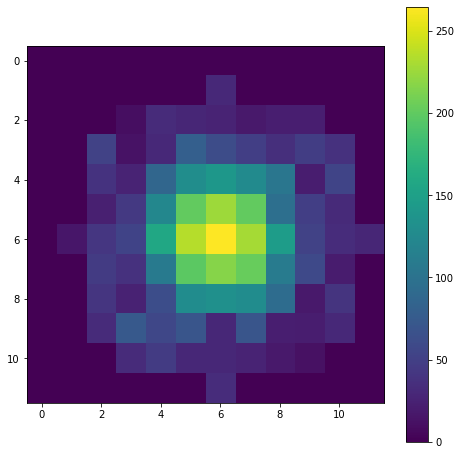

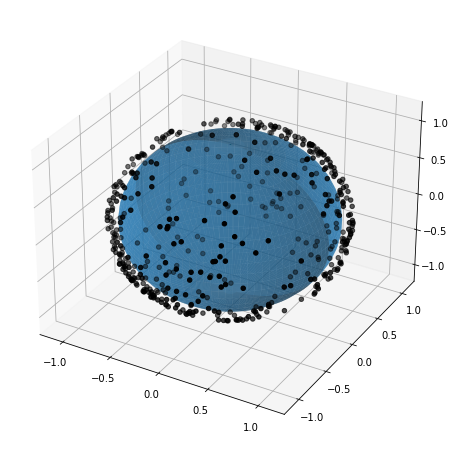

Iter  4
Sampling orientations
  MC sample 100 , loss = 86.07936237134743
  MC sample 200 , loss = 85.79158787801165
  MC sample 300 , loss = 85.60853873363133
  MC sample 400 , loss = 85.49148082616084
  MC sample 500 , loss = 85.39621767502614
  MC sample 600 , loss = 85.30565772378279
  MC sample 700 , loss = 85.2499698424852
  MC sample 800 , loss = 85.15085053647284
  MC sample 900 , loss = 85.11640169044138
  Time orientations sampling = 13.111070156097412
  mean(a_angles) = 0.009931857121660205
Sampling shifts
  MC sample 100 , loss = 85.03172117697125
  MC sample 200 , loss = 84.98563978065884
  MC sample 300 , loss = 84.96058557728148
  MC sample 400 , loss = 84.95744081785139
  MC sample 500 , loss = 84.9565237259418
  MC sample 600 , loss = 84.9338251864106
  MC sample 700 , loss = 84.90579900241907
  MC sample 800 , loss = 84.91005037131968
  MC sample 900 , loss = 84.91181036896971
  Time shifts sampling = 8.510093927383423
  mean(a_shifts) = 0.004008307974164397
Sampling t

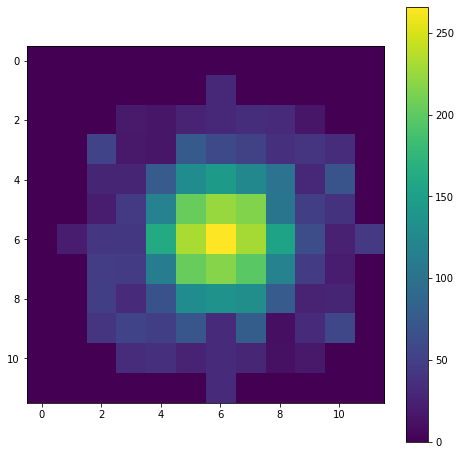

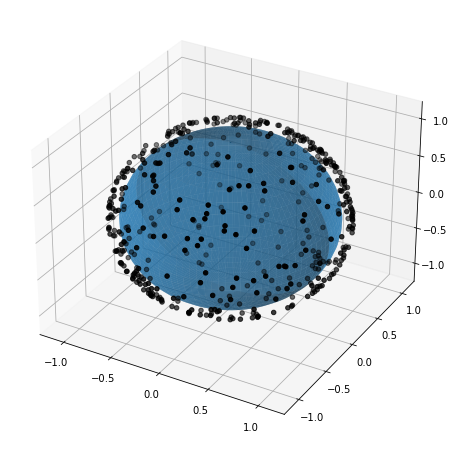

Iter  5
Sampling orientations
  MC sample 100 , loss = 114.28892690356679
  MC sample 200 , loss = 114.19980246303375
  MC sample 300 , loss = 114.0880903200965
  MC sample 400 , loss = 113.9916813579619
  MC sample 500 , loss = 113.90030773106248
  MC sample 600 , loss = 113.82125984095799
  MC sample 700 , loss = 113.76976518737034
  MC sample 800 , loss = 113.72663674133038
  MC sample 900 , loss = 113.68716631610978
  Time orientations sampling = 13.123949527740479
  mean(a_angles) = 0.005434911392358564
Sampling shifts
  MC sample 100 , loss = 113.6043909092343
  MC sample 200 , loss = 113.57649468153357
  MC sample 300 , loss = 113.56494741369109
  MC sample 400 , loss = 113.55960327959832
  MC sample 500 , loss = 113.54004598825225
  MC sample 600 , loss = 113.52330382795815
  MC sample 700 , loss = 113.51407435995667
  MC sample 800 , loss = 113.51374669429018
  MC sample 900 , loss = 113.51199361696992
  Time shifts sampling = 9.44836139678955
  mean(a_shifts) = 0.003767798729

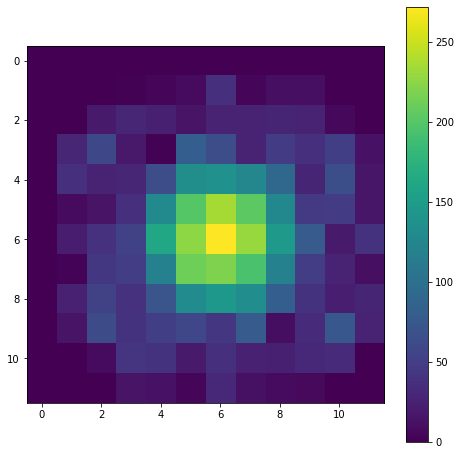

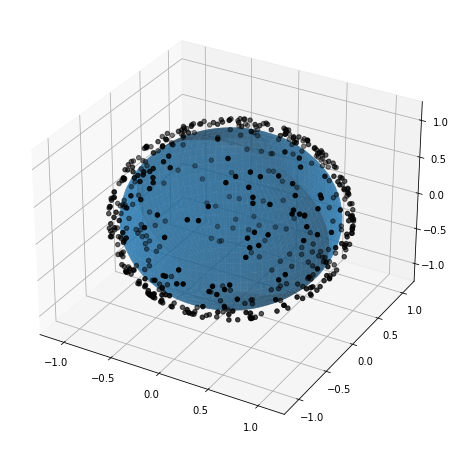

Iter  6
Sampling orientations
  MC sample 100 , loss = 112.61581573174652
  MC sample 200 , loss = 112.48246511817531
  MC sample 300 , loss = 112.39091524039894
  MC sample 400 , loss = 112.32950128604747
  MC sample 500 , loss = 112.27442103917716
  MC sample 600 , loss = 112.2393793652427
  MC sample 700 , loss = 112.19923550851067
  MC sample 800 , loss = 112.16555442014781
  MC sample 900 , loss = 112.13004529694538
  Time orientations sampling = 13.09289813041687
  mean(a_angles) = 0.003499652681117019
Sampling shifts
  MC sample 100 , loss = 112.07222984491928
  MC sample 200 , loss = 112.01689169267627
  MC sample 300 , loss = 112.00990424177456
  MC sample 400 , loss = 112.00735419426486
  MC sample 500 , loss = 112.00593497760825
  MC sample 600 , loss = 112.00806056737723
  MC sample 700 , loss = 111.99906086979803
  MC sample 800 , loss = 111.98361896269944
  MC sample 900 , loss = 111.98869999650333
  Time shifts sampling = 8.354183673858643
  mean(a_shifts) = 0.0034825316

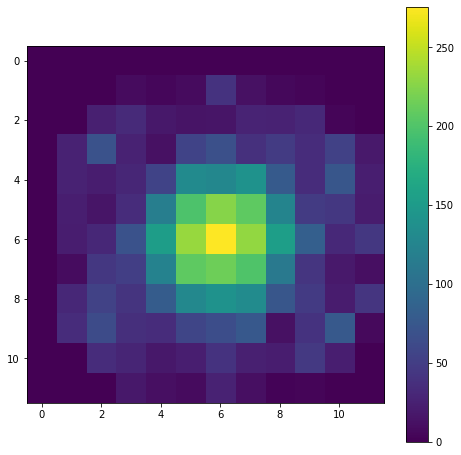

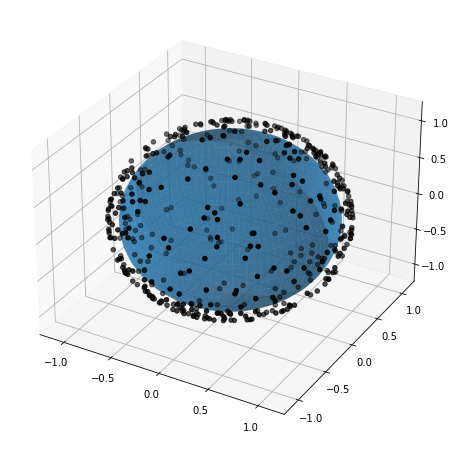

Iter  7
Sampling orientations
  MC sample 100 , loss = 111.85875038949666
  MC sample 200 , loss = 111.80477583364907
  MC sample 300 , loss = 111.75602532733761
  MC sample 400 , loss = 111.73010451970632
  MC sample 500 , loss = 111.66454257648503
  MC sample 600 , loss = 111.62263120409851
  MC sample 700 , loss = 111.58985729668798
  MC sample 800 , loss = 111.56259888755098
  MC sample 900 , loss = 111.54266933290079
  Time orientations sampling = 13.129467010498047
  mean(a_angles) = 0.0027040361878736103
Sampling shifts
  MC sample 100 , loss = 111.50281063719855
  MC sample 200 , loss = 111.48910326797449
  MC sample 300 , loss = 111.49673375208064
  MC sample 400 , loss = 111.48248911745829
  MC sample 500 , loss = 111.47327502861576
  MC sample 600 , loss = 111.48039361283507
  MC sample 700 , loss = 111.47365875785805
  MC sample 800 , loss = 111.47416409620185
  MC sample 900 , loss = 111.44580353341443
  Time shifts sampling = 9.24938154220581
  mean(a_shifts) = 0.00334317

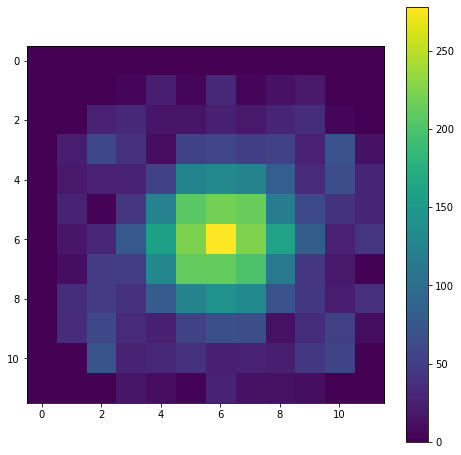

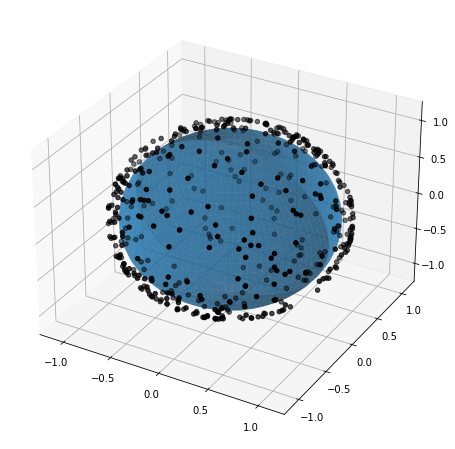

Iter  8
Sampling orientations
  MC sample 100 , loss = 111.43336516616343
  MC sample 200 , loss = 111.38550534716245
  MC sample 300 , loss = 111.36364121648181
  MC sample 400 , loss = 111.33361554328553
  MC sample 500 , loss = 111.30823135258835
  MC sample 600 , loss = 111.27748632456053
  MC sample 700 , loss = 111.2446766636929
  MC sample 800 , loss = 111.25489338741755
  MC sample 900 , loss = 111.2279617885782
  Time orientations sampling = 13.119812965393066
  mean(a_angles) = 0.0023500521393969376
Sampling shifts
  MC sample 100 , loss = 111.18715627135145
  MC sample 200 , loss = 111.1854760999078
  MC sample 300 , loss = 111.18102698499273
  MC sample 400 , loss = 111.17381120092385
  MC sample 500 , loss = 111.15620783853132
  MC sample 600 , loss = 111.16332549289957
  MC sample 700 , loss = 111.17021715541047
  MC sample 800 , loss = 111.17738499848589
  MC sample 900 , loss = 111.15749924884511
  Time shifts sampling = 9.4211745262146
  mean(a_shifts) = 0.003292941916

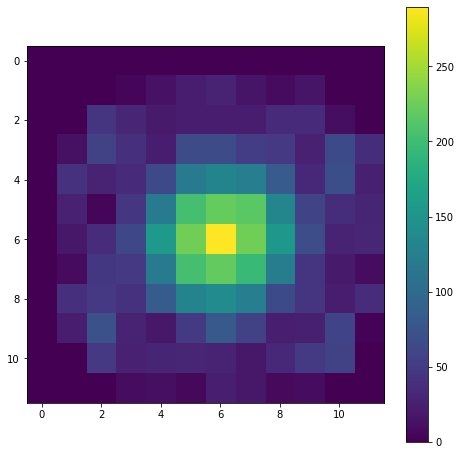

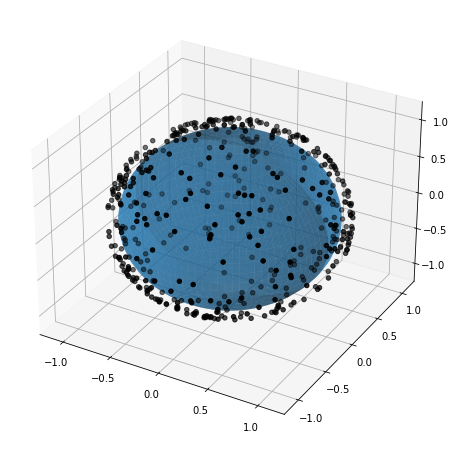

Iter  9
Sampling orientations
  MC sample 100 , loss = 149.80101205744666
  MC sample 200 , loss = 149.7660200709823
  MC sample 300 , loss = 149.7049559590784
  MC sample 400 , loss = 149.6846051037999
  MC sample 500 , loss = 149.67658931382013
  MC sample 600 , loss = 149.65784113527934
  MC sample 700 , loss = 149.62887311944905
  MC sample 800 , loss = 149.61561318031903
  MC sample 900 , loss = 149.58356175839359
  Time orientations sampling = 16.952281713485718
  mean(a_angles) = 0.0021159007045012585
Sampling shifts
  MC sample 100 , loss = 149.54489815801386
  MC sample 200 , loss = 149.55711915229537
  MC sample 300 , loss = 149.53032453628643
  MC sample 400 , loss = 149.53844621241123
  MC sample 500 , loss = 149.51619066293242
  MC sample 600 , loss = 149.51533525570855
  MC sample 700 , loss = 149.50544265420544
  MC sample 800 , loss = 149.48649880382763
  MC sample 900 , loss = 149.49280235635035
  Time shifts sampling = 9.023185014724731
  mean(a_shifts) = 0.0032308647

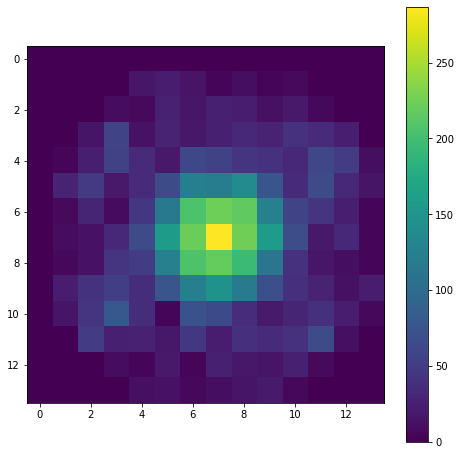

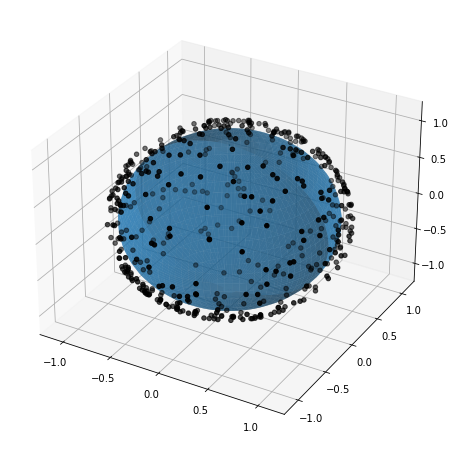

Iter  10
Sampling orientations
  MC sample 100 , loss = 148.76951605689595
  MC sample 200 , loss = 148.7022232198644
  MC sample 300 , loss = 148.63668191600476
  MC sample 400 , loss = 148.5902195429258
  MC sample 500 , loss = 148.55505905648374
  MC sample 600 , loss = 148.51318182404984
  MC sample 700 , loss = 148.48300691264032
  MC sample 800 , loss = 148.45211146995
  MC sample 900 , loss = 148.4238532375867
  Time orientations sampling = 16.06841516494751
  mean(a_angles) = 0.0018230531893825357
Sampling shifts
  MC sample 100 , loss = 148.36241351733247
  MC sample 200 , loss = 148.3394075224123
  MC sample 300 , loss = 148.29621249751207
  MC sample 400 , loss = 148.29245903397216
  MC sample 500 , loss = 148.28268471199885
  MC sample 600 , loss = 148.2722624125004
  MC sample 700 , loss = 148.2669789095994
  MC sample 800 , loss = 148.27850237856885
  MC sample 900 , loss = 148.26853335374125
  Time shifts sampling = 9.885559558868408
  mean(a_shifts) = 0.0030860389646629

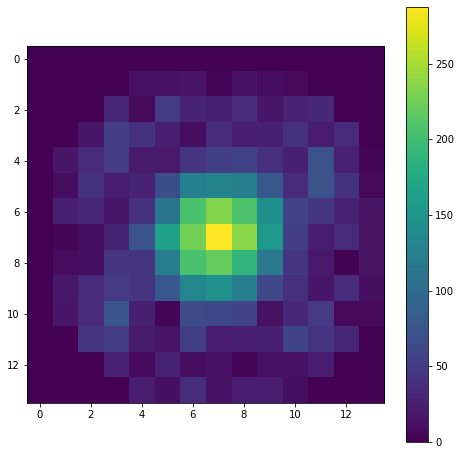

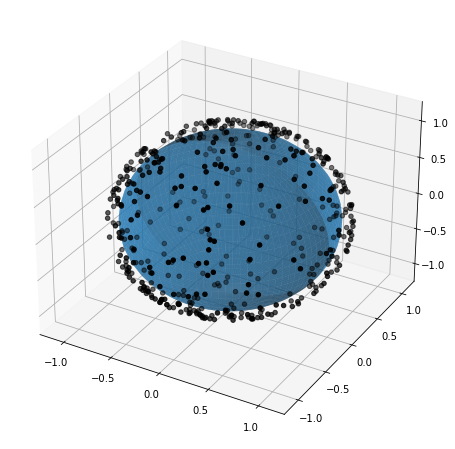

Iter  11
Sampling orientations
  MC sample 100 , loss = 148.2688558112421
  MC sample 200 , loss = 148.2329020483922
  MC sample 300 , loss = 148.20509574314968
  MC sample 400 , loss = 148.1864800435986
  MC sample 500 , loss = 148.13789391021166
  MC sample 600 , loss = 148.11576089739927
  MC sample 700 , loss = 148.1105415455498
  MC sample 800 , loss = 148.08906932725245
  MC sample 900 , loss = 148.07295509901442
  Time orientations sampling = 16.12118411064148
  mean(a_angles) = 0.001497765312051697
Sampling shifts
  MC sample 100 , loss = 148.02371306366558
  MC sample 200 , loss = 148.02437979958083
  MC sample 300 , loss = 148.00318769679913
  MC sample 400 , loss = 147.9936156431472
  MC sample 500 , loss = 147.98806158625942
  MC sample 600 , loss = 147.9732914590521
  MC sample 700 , loss = 147.96942106041539
  MC sample 800 , loss = 147.97570122070994
  MC sample 900 , loss = 147.95997155319873
  Time shifts sampling = 9.677304983139038
  mean(a_shifts) = 0.00296428070812

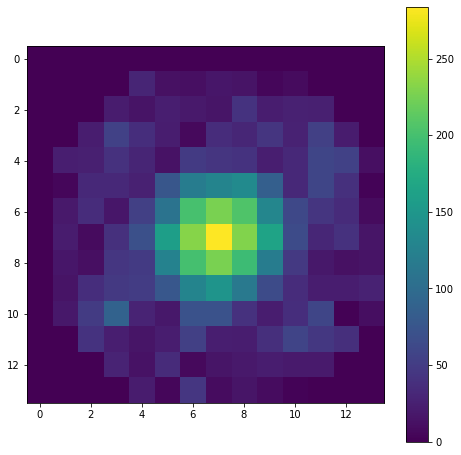

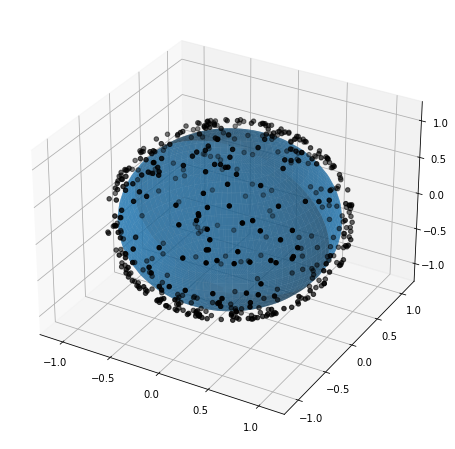

Iter  12
Sampling orientations
  MC sample 100 , loss = 148.01609944104482
  MC sample 200 , loss = 147.960937298101
  MC sample 300 , loss = 147.917117440366
  MC sample 400 , loss = 147.90281035457193
  MC sample 500 , loss = 147.86785402389336
  MC sample 600 , loss = 147.85382007977213
  MC sample 700 , loss = 147.83059162285616
  MC sample 800 , loss = 147.82381414356885
  MC sample 900 , loss = 147.8031424868627
  Time orientations sampling = 16.08576989173889
  mean(a_angles) = 0.0013338679102275059
Sampling shifts
  MC sample 100 , loss = 147.7801006951081
  MC sample 200 , loss = 147.7703543938025
  MC sample 300 , loss = 147.76516699043344
  MC sample 400 , loss = 147.7538367440063
  MC sample 500 , loss = 147.74492703893816
  MC sample 600 , loss = 147.73329148164737
  MC sample 700 , loss = 147.72396130321314
  MC sample 800 , loss = 147.71123524268856
  MC sample 900 , loss = 147.71659830827443
  Time shifts sampling = 9.994960308074951
  mean(a_shifts) = 0.002942016114668

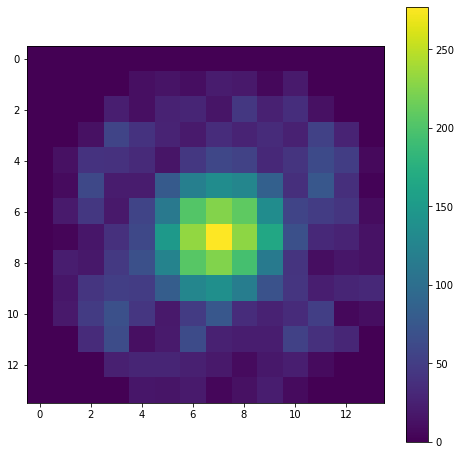

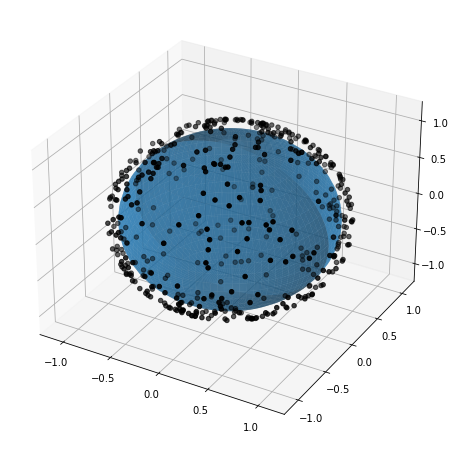

Iter  13
Sampling orientations
  MC sample 100 , loss = 197.06455381276868
  MC sample 200 , loss = 197.02228424358123
  MC sample 300 , loss = 197.0030162233248
  MC sample 400 , loss = 196.969470768936
  MC sample 500 , loss = 196.94756642079992
  MC sample 600 , loss = 196.9369671306455
  MC sample 700 , loss = 196.92413064425295
  MC sample 800 , loss = 196.89436796867477
  MC sample 900 , loss = 196.88419893886783
  Time orientations sampling = 18.056145906448364
  mean(a_angles) = 0.0012105713552442387
Sampling shifts
  MC sample 100 , loss = 196.85890349683237
  MC sample 200 , loss = 196.83963434635658
  MC sample 300 , loss = 196.81315781262302
  MC sample 400 , loss = 196.8109511735849
  MC sample 500 , loss = 196.81564723409645
  MC sample 600 , loss = 196.80908150941136
  MC sample 700 , loss = 196.79186553196269
  MC sample 800 , loss = 196.78324534785443
  MC sample 900 , loss = 196.78065765733646
  Time shifts sampling = 9.396988868713379
  mean(a_shifts) = 0.00287778409

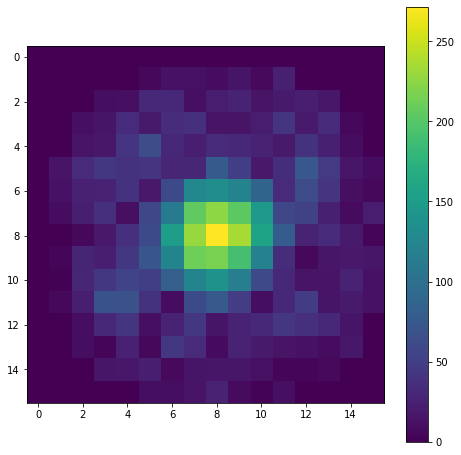

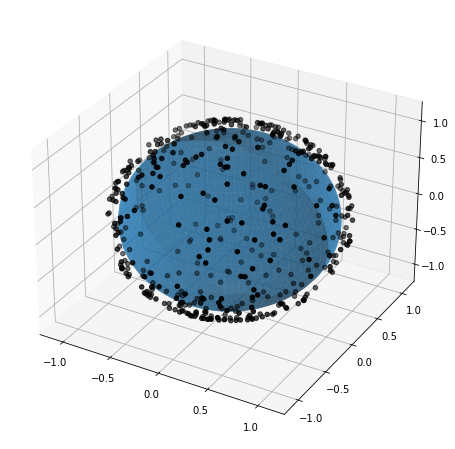

Iter  14
Sampling orientations
  MC sample 100 , loss = 196.64813689336927
  MC sample 200 , loss = 196.602648332983
  MC sample 300 , loss = 196.5678502857583
  MC sample 400 , loss = 196.53132422030052
  MC sample 500 , loss = 196.50383301845977
  MC sample 600 , loss = 196.4651501244138
  MC sample 700 , loss = 196.44038783940636
  MC sample 800 , loss = 196.42259557830334
  MC sample 900 , loss = 196.40395129259318
  Time orientations sampling = 17.80067801475525
  mean(a_angles) = 0.0010745040162775375
Sampling shifts
  MC sample 100 , loss = 196.34382834010768
  MC sample 200 , loss = 196.33468440075129
  MC sample 300 , loss = 196.33595537092208
  MC sample 400 , loss = 196.32184255460456
  MC sample 500 , loss = 196.30713249265352
  MC sample 600 , loss = 196.29629984813482
  MC sample 700 , loss = 196.30207519193021
  MC sample 800 , loss = 196.3013170969459
  MC sample 900 , loss = 196.2947956461075
  Time shifts sampling = 10.11434531211853
  mean(a_shifts) = 0.0027591815010

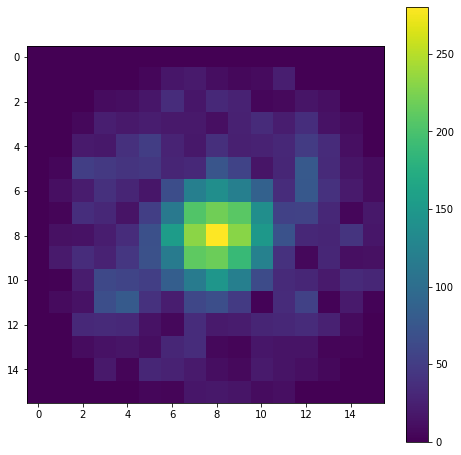

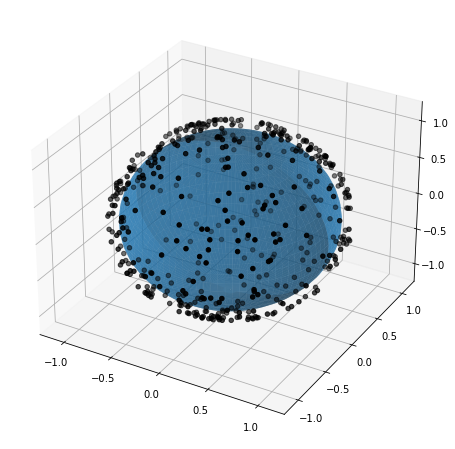

Iter  15
Sampling orientations
  MC sample 100 , loss = 196.37072611027858
  MC sample 200 , loss = 196.34574638520286
  MC sample 300 , loss = 196.3105758054275
  MC sample 400 , loss = 196.2892513314108
  MC sample 500 , loss = 196.2669675426067
  MC sample 600 , loss = 196.2428883351597
  MC sample 700 , loss = 196.221671698898
  MC sample 800 , loss = 196.20397935947474
  MC sample 900 , loss = 196.1867987239171
  Time orientations sampling = 17.744040489196777
  mean(a_angles) = 0.0009740782020563657
Sampling shifts
  MC sample 100 , loss = 196.1295148874643
  MC sample 200 , loss = 196.1261958511223
  MC sample 300 , loss = 196.10508746872182
  MC sample 400 , loss = 196.10021391515056
  MC sample 500 , loss = 196.09147950154613
  MC sample 600 , loss = 196.0997145878627
  MC sample 700 , loss = 196.1019137161513
  MC sample 800 , loss = 196.08157409221963
  MC sample 900 , loss = 196.0816992474713
  Time shifts sampling = 10.01640796661377
  mean(a_shifts) = 0.002713912204829486

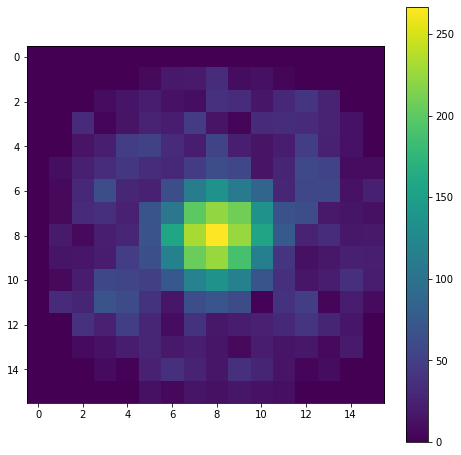

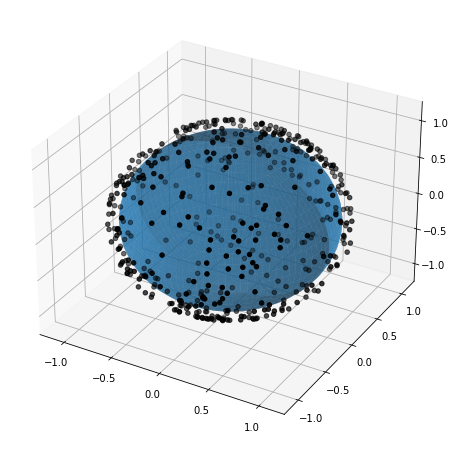

Iter  16
Sampling orientations
  MC sample 100 , loss = 196.1359020576962
  MC sample 200 , loss = 196.10251360114412
  MC sample 300 , loss = 196.0764555802147
  MC sample 400 , loss = 196.05534296770608
  MC sample 500 , loss = 196.0233191184316
  MC sample 600 , loss = 195.9989572778983
  MC sample 700 , loss = 195.97624933524116
  MC sample 800 , loss = 195.95060171409827
  MC sample 900 , loss = 195.92690289149226
  Time orientations sampling = 17.876445531845093
  mean(a_angles) = 0.0008830019810773734
Sampling shifts
  MC sample 100 , loss = 195.8964210290251
  MC sample 200 , loss = 195.87849926440416
  MC sample 300 , loss = 195.86456466023319
  MC sample 400 , loss = 195.8492296633291
  MC sample 500 , loss = 195.84462295366518
  MC sample 600 , loss = 195.8505565787711
  MC sample 700 , loss = 195.84236050277232
  MC sample 800 , loss = 195.82838570748393
  MC sample 900 , loss = 195.8425731709746
  Time shifts sampling = 10.22891092300415
  mean(a_shifts) = 0.00269833704172

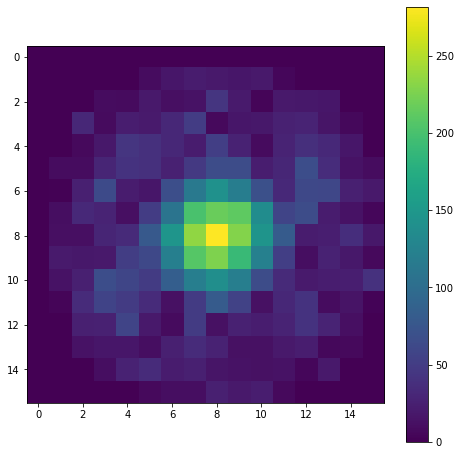

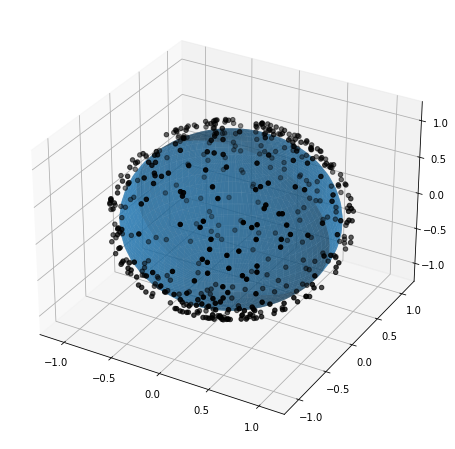

Iter  17
Sampling orientations
  MC sample 100 , loss = 252.29827959384627
  MC sample 200 , loss = 252.26207080783195
  MC sample 300 , loss = 252.2361427405045
  MC sample 400 , loss = 252.21506504307408
  MC sample 500 , loss = 252.1858084459831
  MC sample 600 , loss = 252.175723579771
  MC sample 700 , loss = 252.15834654185363
  MC sample 800 , loss = 252.13551788953032
  MC sample 900 , loss = 252.11569600767228
  Time orientations sampling = 21.480645179748535
  mean(a_angles) = 0.0008381819068766598
Sampling shifts
  MC sample 100 , loss = 252.09795610670923
  MC sample 200 , loss = 252.07951470660223
  MC sample 300 , loss = 252.07907849998625
  MC sample 400 , loss = 252.07354981502476
  MC sample 500 , loss = 252.06537449810827
  MC sample 600 , loss = 252.06780465418382
  MC sample 700 , loss = 252.0551283532851
  MC sample 800 , loss = 252.03633833007385
  MC sample 900 , loss = 252.04251630162997
  Time shifts sampling = 9.91506576538086
  mean(a_shifts) = 0.002620432019

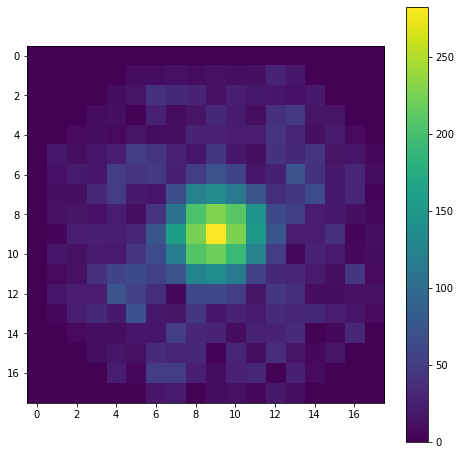

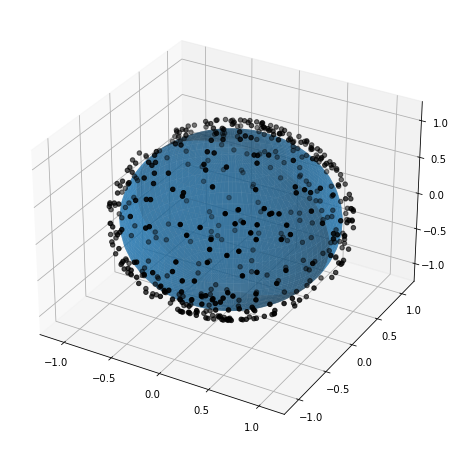

Iter  18
Sampling orientations
  MC sample 100 , loss = 252.2063659557181
  MC sample 200 , loss = 252.17914082282826
  MC sample 300 , loss = 252.15083541110337
  MC sample 400 , loss = 252.13652837438812
  MC sample 500 , loss = 252.11527702152088
  MC sample 600 , loss = 252.06960215932682
  MC sample 700 , loss = 252.06156911577733


In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

N_samples = 1000
N_iter = 100000

dr = 0.05
radius = 0.2
#alpha = 0.001
alpha = 1e-10

use_sgd = True

N_cg_iter = 1000

N_sgd_iter = 100
batch_size = 500
learning_rate = 1
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

vol0 = None
angles0 = None
shifts0 = None
    
N_samples_vol = 101
N_samples_angles = 1000
N_samples_shifts = 1000

eps_vol = 2e-5

# HMC params
dt_list = jnp.array([0.1, 0.5, 1, 5])
L = 10

# boundary for sampling shifts in [-B, B]^2
B = pixel_size*nx/10

out_dir = '../data/ab_initio/'
imgs = imgs.reshape([N, nx*nx])
#v_rec, angles_rec = ab_initio(project, imgs, sigma_noise, shifts_true, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec, shifts_rec = ab_initio_mcmc(key, 
                                   project, 
                                   rotate_and_interpolate,
                                   apply_shifts_and_ctf,
                                   imgs, 
                                   sigma_noise, 
                                   ctf_params, 
                                   x_grid, 
                                   use_sgd, 
                                   vol0,
                                   angles0,
                                   shifts0,
                                   N_iter, 
                                   learning_rate, 
                                   batch_size, 
                                   P, 
                                   N_samples_vol,
                                   N_samples_angles, 
                                   N_samples_shifts,
                                   dt_list, 
                                   L, 
                                   radius, 
                                   dr, 
                                   alpha, 
                                   eps_vol,
                                   B,
                                   'tri', 
                                   True, True, True, out_dir)


In [ ]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[:,:,0])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

In [ ]:
plot_angles(angles_rec[:1000])

In [ ]:
shifts_err = wrap_arround_distance_2d_array(shifts_true, shifts_rec, 10)
print("mean shift error =", jnp.mean(shifts_err), "in [", -10, ",", 10, "]^2")
plt.plot(shifts_err)

In [ ]:
plot_angles(angles_true[:1000])

## Optimization with respect to volume

### CG - applied to two halves of the data

In [43]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 600
eps_cg = 1e-5

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 100000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, eps_cg, verbose = True)

  cg iter 0 ||r|| = 64.0999131168545
  cg iter 50 ||r|| = 0.00022445505923135778
  cg iter 100 ||r|| = 9.904533574292494e-05
  cg iter 150 ||r|| = 5.536797285466404e-05
  cg iter 200 ||r|| = 3.191014759157713e-05
  cg iter 250 ||r|| = 2.6158492823062747e-05
  cg iter 300 ||r|| = 2.5489091313994322e-05
  cg iter 350 ||r|| = 2.5521880315329098e-05
  cg iter 400 ||r|| = 2.2327517957044257e-05
  cg iter 450 ||r|| = 1.8715437013090208e-05
  cg iter 500 ||r|| = 1.5610226409670588e-05
  cg iter 550 ||r|| = 1.5686219118109472e-05


In [45]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, eps_cg, verbose = True)

  cg iter 0 ||r|| = 73.69929948438595
  cg iter 50 ||r|| = 0.00016700125237854795
  cg iter 100 ||r|| = 5.8671104429629774e-05
  cg iter 150 ||r|| = 3.586747732177588e-05
  cg iter 200 ||r|| = 3.0431897624318876e-05
  cg iter 250 ||r|| = 2.370623291835185e-05
  cg iter 300 ||r|| = 2.339111653712353e-05
  cg iter 350 ||r|| = 2.5356056414641797e-05
  cg iter 400 ||r|| = 2.201810842703514e-05
  cg iter 450 ||r|| = 2.1754316144376644e-05
  cg iter 500 ||r|| = 1.778383940300002e-05
  cg iter 550 ||r|| = 1.6398462698863898e-05


In [44]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.4922433392098166
Absolute error =  3.662052789934649


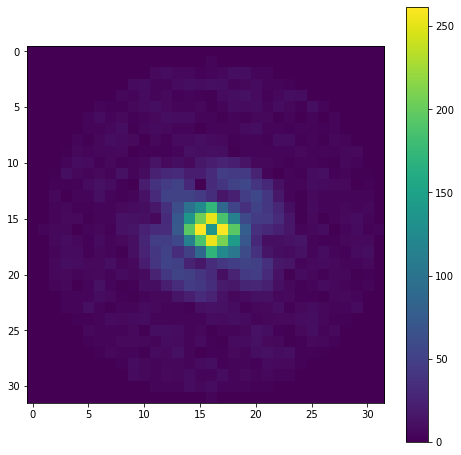

In [45]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

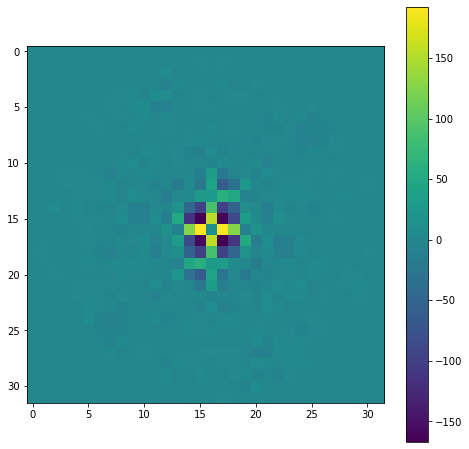

In [46]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

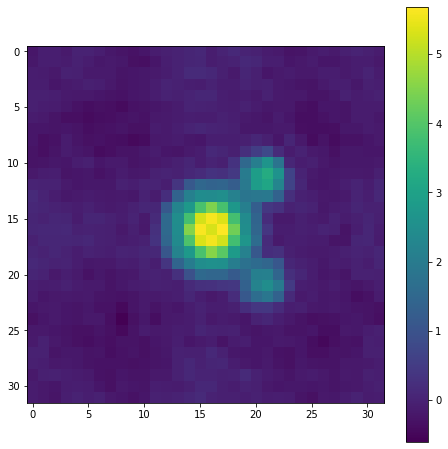

In [48]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

Text(0.5, 1.0, 'Reconstruction MIP')

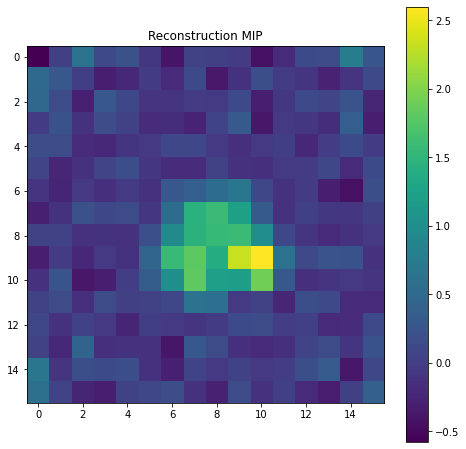

In [212]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

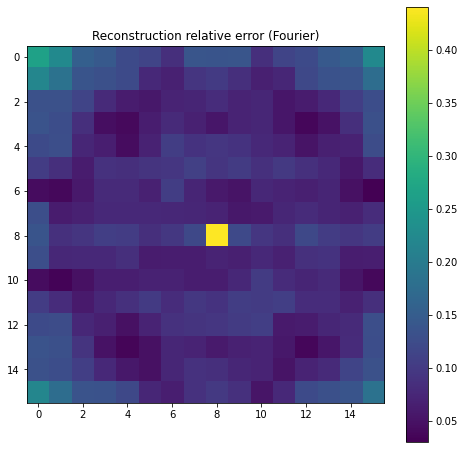

In [64]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

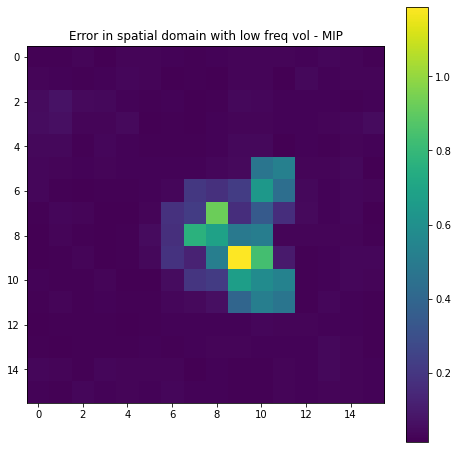

In [198]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

In [45]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))

with mrcfile.new('../data/simulated_rec_vhmc.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

In [46]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier)))

with mrcfile.new('../data/simulated_vol_16.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

### FSC

In [163]:
res, fsc, shell_points = calc_fsc(vcg1, v_hmc_max, x_grid, dr = 0.05)

In [164]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], int(x_grid[1]))
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


In [ ]:
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [166]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

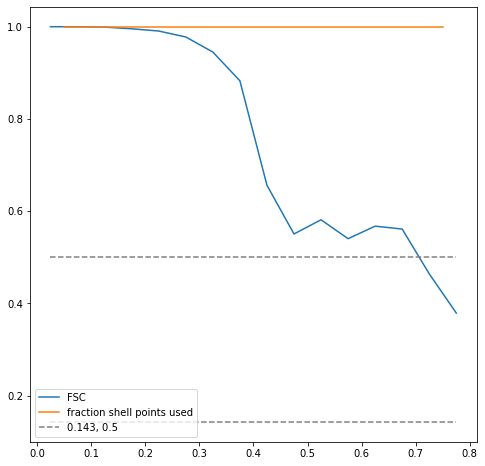

In [167]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

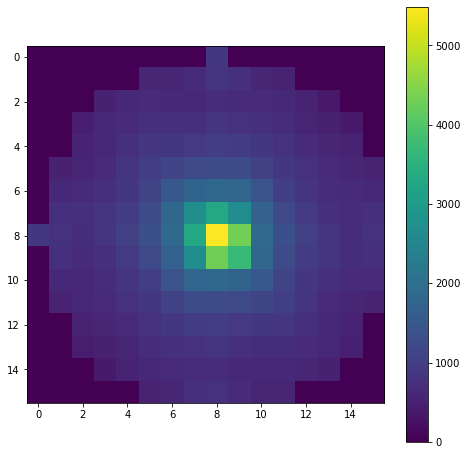

In [57]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [58]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

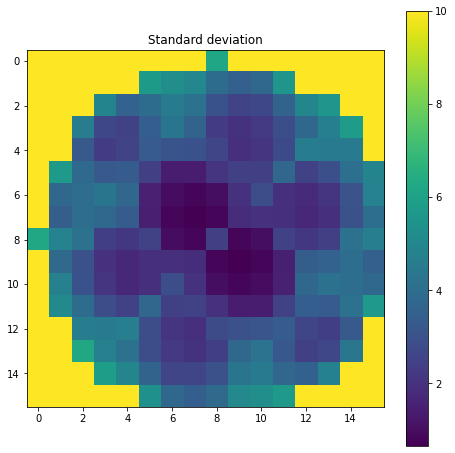

In [59]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

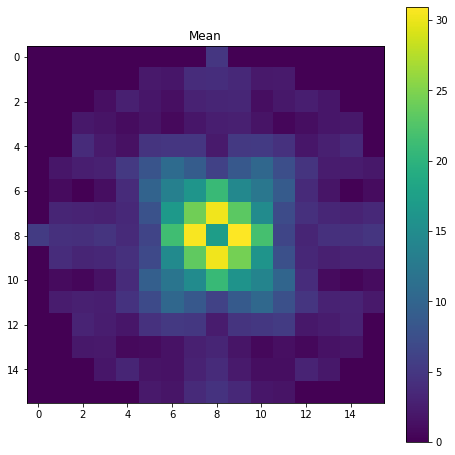

In [60]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

### SGD

#### A preconditioner

0.011098890110988899
1.0


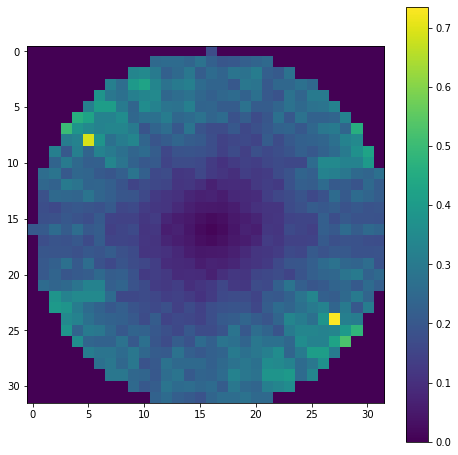

In [254]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1/P  * mask

P = P/jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))

In [65]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
batch_size = N/2
N_epoch = 100
eps_gd = 1e-3
learning_rate = 1
#alpha = 100000 # <- with normalized precon

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_true, shifts_true, ctf_params, imgs)
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, None, eps_gd, True)

print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles_true, shifts_true, ctf_params, imgs, 1)))
print("Relative error = ", jnp.max(jnp.abs((vgd - vol_fourier)/jnp.max(vol_fourier))))

  sgd epoch 0: mean gradient = 0.042522726770200386
  sgd epoch 10: mean gradient = 0.0030659381781304672
  sgd epoch 20: mean gradient = 0.0016716639562312395
  sgd epoch 30: mean gradient = 0.0007006905204310624


TypeError: loss_func_batched() missing 1 required positional argument: 'sigma'

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

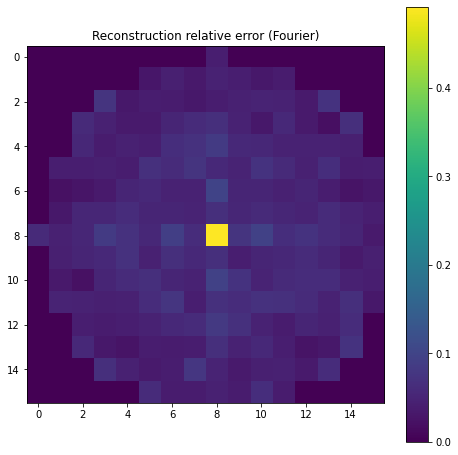

In [67]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd*mask-vol_fourier*mask)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

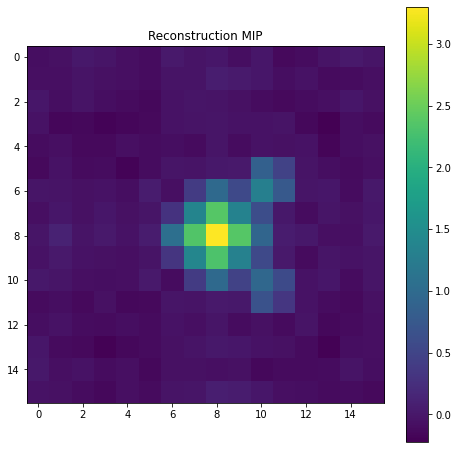

In [68]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd[:,:,0]*mask[:,:,0]))))
plt.colorbar()
plt.title('Reconstruction MIP')

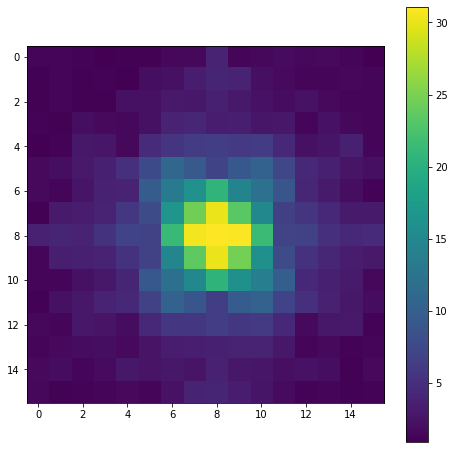

In [69]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

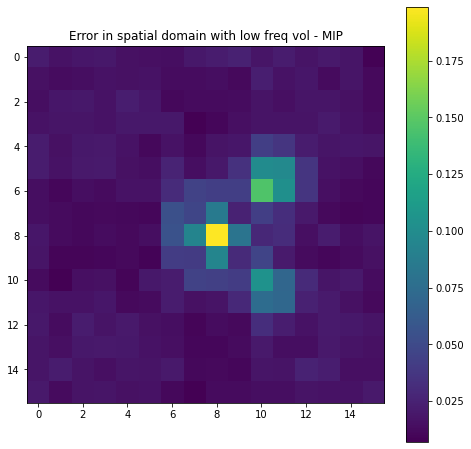

In [70]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - vgd*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

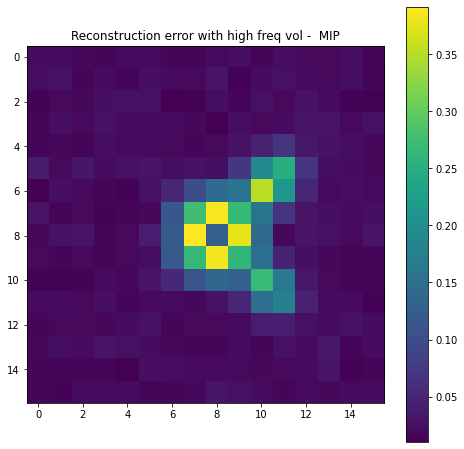

In [71]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vgd)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

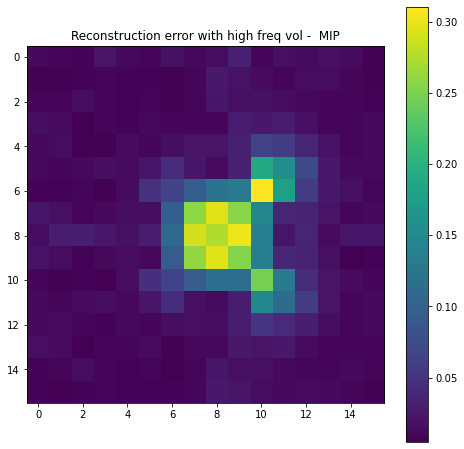

In [72]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

### Volume residual

In [22]:
#alpha = 1e-10
alpha = 1e-5

radius_mask = 0.75
mask = create_3d_mask(x_grid, (0,0,0), radius_mask)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [23]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 5000
eps_cg = 1e-5

N_train = jnp.floor(N/2).astype(jnp.int64)
AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N_train], shifts_true[:N_train], ctf_params[:N_train], imgs[:N_train], v0.shape, sigma_noise)

v_train,_ = conjugate_gradient(AA, Ab, v0, N_iter, eps_cg, verbose = True)

  cg iter 0 ||r|| = 0.0438027382447892
  cg iter 50 ||r|| = 4.8303001359695344e-05
  cg iter 100 ||r|| = 2.7372043812015585e-05
  cg iter 150 ||r|| = 1.8385717922028983e-05
  cg iter 200 ||r|| = 2.2919685492922857e-05
  cg iter 250 ||r|| = 1.7078214447343223e-05
  cg iter 300 ||r|| = 1.8150638896641013e-05
  cg iter 350 ||r|| = 1.47488064208539e-05
  cg iter 400 ||r|| = 1.4620664405688343e-05
  cg iter 414 ||r|| = 9.963732327016209e-06


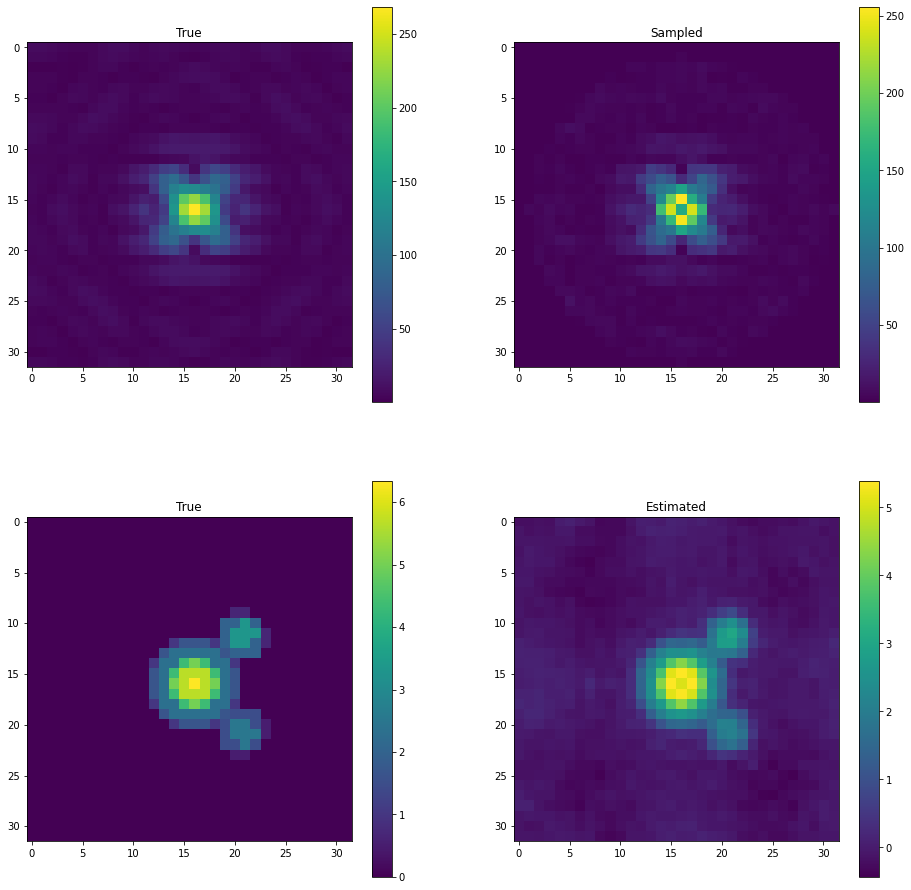

In [24]:
plot_true_vs_estimated(vol_fourier, v_train)

#### Create the volume

Set enough batches so that each batch fits in the GPU memory.
Also, more batches is better as one big batch takes ages to compile on 
the GPU.
The initial compilation takes quite a while, then it's fast.
At some point it slows down, probably to recompile (likely 
for the one batch that has a different size, although I don't
know why that happens at about 33% and not at the end).

100%|██████████| 60000/60000 [01:19<00:00, 756.50it/s] 


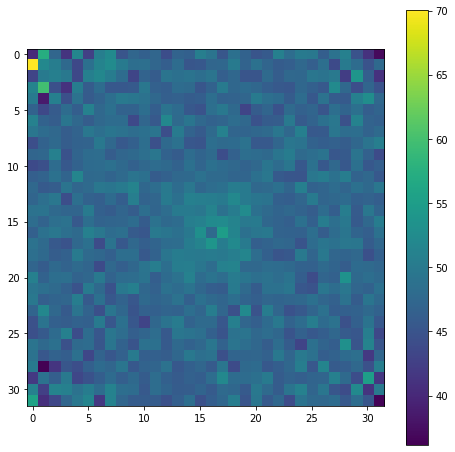

In [30]:
N_batches = 60000

v_resid = get_volume_residual(v_train, angles_true[N_train:], shifts_true[N_train:], ctf_params[N_train:], imgs[N_train:], x_grid, slice_func_array, N_batches)

plt.imshow(jnp.fft.fftshift(v_resid[:,:,0])); plt.colorbar()

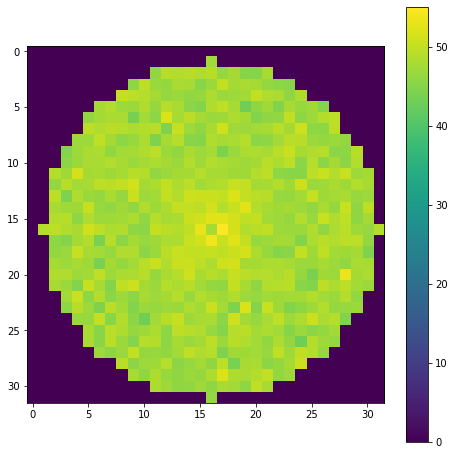

In [31]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

In [34]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)

with mrcfile.new('../data/resid_vol.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))